### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import snippets as sp


In [4]:
reload(sp)
sp.sniplist()
sp.tmetro()

tdf: basic pandas dataframe
tfig: fig with subpanels
tmask: planktom mask and csize, csizebroad
tmetro: colours metro
tmodi: desc dict for model
txr: xarray dataset
tylist: yearlist maker for nemo output
metro = ['#6db8ff', '#de4231','#f3c108','#02954f','#01529b']
#skyblue, red, yellow, green, blue
20 named cols by sasha trubetskoy:
tcol = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']'


## dict of runs and colours

In [5]:
tcol = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', \
        '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
        '#bcf60c', '#fabebe', '#008080', '#e6beff', \
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

modi = {
    'KDD0': {'tcol': 'darkgrey', 'tdesc': 'SR', 'tlw': 1.5},
    'KWD0': {'tcol': 'r', 'tdesc': 'no SR', 'tlw': 1.5},
    'KFD0': {'tcol': tcol[0], 'tdesc': 'flxcorr north atl, monthly', 'tlw': 1.5},
    'KFD1': {'tcol': tcol[1], 'tdesc': 'flxcorr north atl, yearly', 'tlw': 1.5},
    'KFD2': {'tcol': tcol[2], 'tdesc': 'flxcorr global, yearly', 'tlw': 1.5},
    'KFD3': {'tcol': tcol[3], 'tdesc': 'flxcorr global, monthly', 'tlw': 1.5},
    'KFD4': {'tcol': tcol[4], 'tdesc': 'flxcorr global, monthly2x', 'tlw': 1.5},
    'KFD5': {'tcol': tcol[5], 'tdesc': 'flxcorr global, monthly5x', 'tlw': 1.5},
    'KFD6': {'tcol': tcol[6], 'tdesc': 'flxcorr global, monthly10x', 'tlw': 1.5},
    'KFD7': {'tcol': tcol[7], 'tdesc': 'flxcorr glob, monthly, pos only', 'tlw': 1.5},
    'KDD1': {'tcol': tcol[8], 'tdesc': 'SR, 2x rn_deds', 'tlw': 1.5},
    'KDD2': {'tcol': tcol[9], 'tdesc': 'SR, 0.1 rn_deds', 'tlw': 1.5},
    'KDD3': {'tcol': tcol[10], 'tdesc': 'SR, 4x rn_deds', 'tlw': 1.5},
    'KCW0': {'tcol': tcol[11], 'tdesc': 'no TR no SR', 'tlw': 1.5},
    'KCD0': {'tcol': tcol[12], 'tdesc': 'no TR yes SR', 'tlw': 1.5},
}
    
runs = ['KWD0','KDD0','KFD0','KFD1','KFD2',\
        'KFD3','KFD4','KFD5','KFD6','KDD1',\
        'KDD2','KFD7','KDD3','KCW0','KCD0']

## get out wfo and sos for 1955-1964 and 2005-2014



sss_5564.nc - 1955-1964
sss_A5B4.nc - 2005-2014



In [6]:
ex = False
tmask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/mesh_mask3_6.nc')

col_labels = ['tmaskutil','A1','A2','ARCTIC']


def extract_mean(runs,col_labels,y1,y2,tdat):

    df = pd.DataFrame(0, index=runs, columns=col_labels)

    for r in runs:
        print(r)
        w = xr.open_dataset(f'./data/{r}_{tdat}.nc')
        w1 = w[tdat].sel(time_counter=slice(f'{y1}-01-01', f'{y2}-12-31'))
        for col in col_labels:
            tmask['test'] = tmask['csize']*tmask[col][0,:,:]
            #w2 = w1.weighted(tmask['test']).mean(dim = ['y','x']).values
            w2 = w1.weighted(tmask['test']).mean(dim = ['y','x']).values
            df.loc[r, col] = np.nanmean(w2)
            print(np.nanmean(w2))
            
    df.to_csv(f'./data/mean_{tdat}-{y1}-{y2}.csv')

runs = ['KWD0','KDD0','KFD0','KFD1','KFD2',\
        'KFD3','KFD4','KFD5','KFD6','KDD1',\
        'KDD2','KFD7','KDD3','KCW0','KCD0']
    
# runs = ['KCW0']
    
# tdat = 'sos'
# extract_mean(runs,col_labels,y1,y2,tdat) 
    
if ex:
    
    y1 = 1955; y2 = 1964; tdat = 'wfo'
    extract_mean(runs,col_labels,y1,y2,tdat)
    tdat = 'sos'
    extract_mean(runs,col_labels,y1,y2,tdat) 
    tdat = 'tos'
    extract_mean(runs,col_labels,y1,y2,tdat) 
    
    y1 = 2005; y2 = 2014; tdat = 'wfo'
    extract_mean(runs,col_labels,y1,y2,tdat)
    tdat = 'sos'
    extract_mean(runs,col_labels,y1,y2,tdat)  
    tdat = 'tos'
    extract_mean(runs,col_labels,y1,y2,tdat) 

In [7]:
y1 = 1955; y2 = 1964; tdat = 'sos'
sos_1955 = pd.read_csv(f'./data/mean_{tdat}-{y1}-{y2}.csv', index_col=0)
y1 = 2005; y2 = 2014; 
sos_2005 = pd.read_csv(f'./data/mean_{tdat}-{y1}-{y2}.csv', index_col=0)

y1 = 1955; y2 = 1964; tdat = 'wfo'
wfo_1955 = pd.read_csv(f'./data/mean_{tdat}-{y1}-{y2}.csv', index_col=0)
y1 = 2005; y2 = 2014; 
wfo_2005 = pd.read_csv(f'./data/mean_{tdat}-{y1}-{y2}.csv', index_col=0)

y1 = 1955; y2 = 1964; tdat = 'tos'
tos_1955 = pd.read_csv(f'./data/mean_{tdat}-{y1}-{y2}.csv', index_col=0)
y1 = 2005; y2 = 2014; 
tos_2005 = pd.read_csv(f'./data/mean_{tdat}-{y1}-{y2}.csv', index_col=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


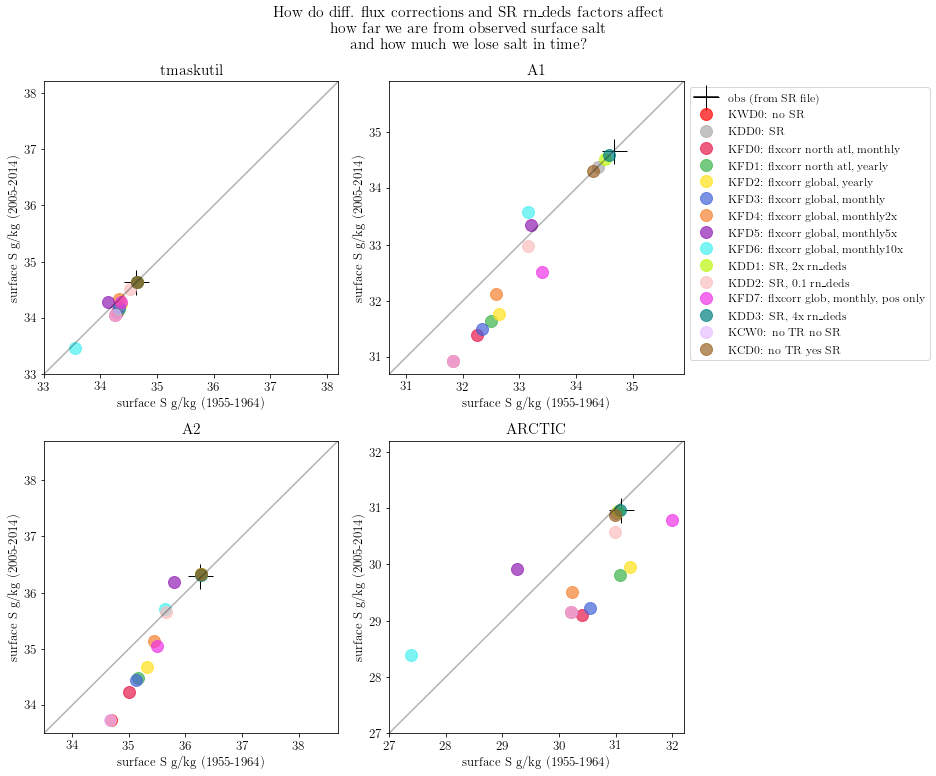

In [8]:
runs = ['KWD0','KDD0','KFD0','KFD1','KFD2',\
        'KFD3','KFD4','KFD5','KFD6','KDD1',\
        'KDD2','KFD7','KDD3','KCW0','KCD0']

# runs = ['KFD6']

fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(12*fact, 10*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

col_labels = ['tmaskutil','A1','A2','ARCTIC']
#mis

ofs = 5.2
mis = [33,30.7, 33.5, 27]

for i in range(0,4):
    col = col_labels[i]
    
    tdir = '/gpfs/data/greenocean/software/products/Restoring/SSS/'
    ss55 = xr.open_dataset(f'{tdir}/sss_5564.nc', decode_times=False)
    tmask['test'] = tmask['csize']*tmask[col][0,:,:]
    w55 = np.mean(ss55.sss.weighted(tmask['test']).mean(dim = ['y','x']).values)

    ss05 = xr.open_dataset(f'{tdir}/sss_A5B4.nc', decode_times=False)
    tmask['test'] = tmask['csize']*tmask[col][0,:,:]
    w05 = np.mean(ss05.sss.weighted(tmask['test']).mean(dim = ['y','x']).values)

    axs[i].plot(w55,w05,color = 'k', marker = '+', markersize = 25, label = 'obs (from SR file)')
    
    for r in runs:
        desc = modi[r]['tdesc']
        axs[i].plot(sos_1955.loc[r, col],sos_2005.loc[r, col], 
                    marker = 'o', markersize = 12, color = modi[r]['tcol'],
                   label = f'{r}: {desc}', alpha = 0.7, linewidth = 0)
    
    
    
    axs[i].plot([27,40],[27,40],'k-', alpha = 0.3)
    axs[i].set_xlim([mis[i],mis[i]+ofs])
    axs[i].set_ylim([mis[i],mis[i]+ofs])
    axs[i].set_ylabel('surface S g/kg (2005-2014)')
    axs[i].set_xlabel('surface S g/kg (1955-1964)')
    axs[i].set_title(col)
    axs[1].legend(ncol = 1, fontsize = 12, bbox_to_anchor = [1,1])
    
plt.suptitle('How do diff. flux corrections and SR rn_deds factors affect \n how far we are from observed surface salt \n and how much we lose salt in time?')
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


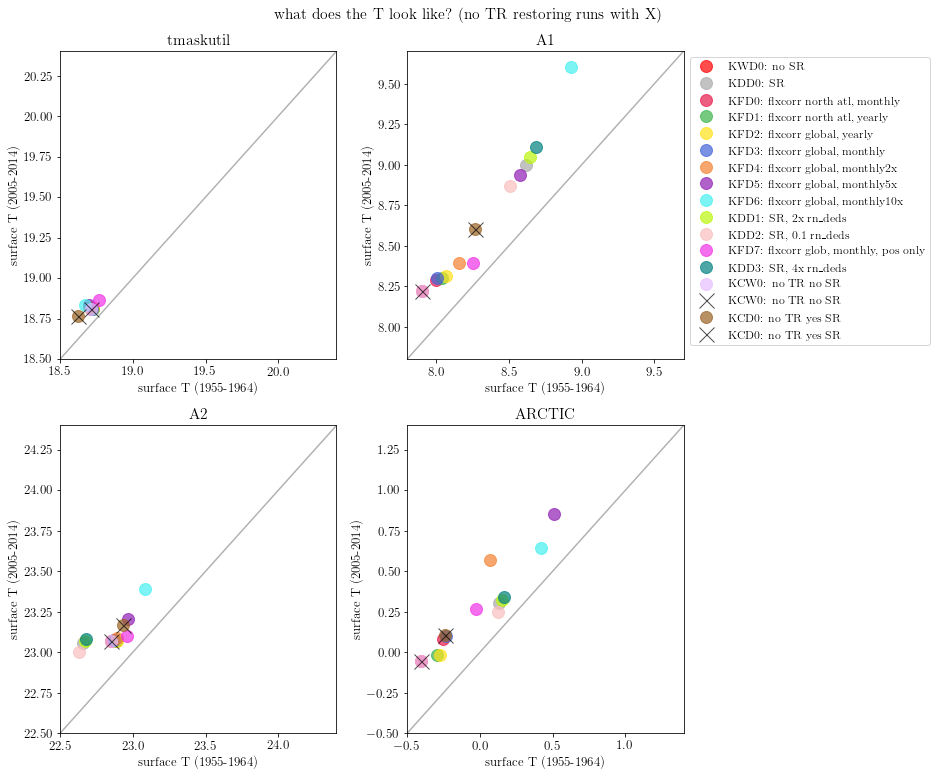

In [24]:
runs = ['KWD0','KDD0','KFD0','KFD1','KFD2',\
        'KFD3','KFD4','KFD5','KFD6','KDD1',\
        'KDD2','KFD7','KDD3','KCW0','KCD0']

# runs = ['KCW0']#,'KCD0']
# # runs = ['KFD6']

runs2 = ['KCW0','KCD0']

fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(12*fact, 10*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

col_labels = ['tmaskutil','A1','A2','ARCTIC']
#mis

ofs = 1.9
mis = [18.5, 7.8, 22.5, -0.5]

for i in range(0,4):
    col = col_labels[i]
    
#     tdir = '/gpfs/data/greenocean/software/products/Restoring/SSS/'
#     ss55 = xr.open_dataset(f'{tdir}/sss_5564.nc', decode_times=False)
#     tmask['test'] = tmask['csize']*tmask[col][0,:,:]
#     w55 = np.mean(ss55.sss.weighted(tmask['test']).mean(dim = ['y','x']).values)

#     ss05 = xr.open_dataset(f'{tdir}/sss_A5B4.nc', decode_times=False)
#     tmask['test'] = tmask['csize']*tmask[col][0,:,:]
#     w05 = np.mean(ss05.sss.weighted(tmask['test']).mean(dim = ['y','x']).values)

#     axs[i].plot(w55,w05,color = 'k', marker = '+', markersize = 25, label = 'obs (from SR file)')
    
    for r in runs:
        desc = modi[r]['tdesc']
        axs[i].plot(tos_1955.loc[r, col],tos_2005.loc[r, col], 
                    marker = 'o', markersize = 12, color = modi[r]['tcol'],
                   label = f'{r}: {desc}', alpha = 0.7, linewidth = 0)
        if r in runs2:
            axs[i].plot(tos_1955.loc[r, col],tos_2005.loc[r, col], 
                        marker = 'x', markersize = 15, color = 'k',
                       label = f'{r}: {desc}', alpha = 0.7, linewidth = 0)    
    
    
    axs[i].plot([-5,45],[-5, 45],'k-', alpha = 0.3)
    axs[i].set_xlim([mis[i],mis[i]+ofs])
    axs[i].set_ylim([mis[i],mis[i]+ofs])
    axs[i].set_ylabel('surface T (2005-2014)')
    axs[i].set_xlabel('surface T (1955-1964)')
    axs[i].set_title(col)
    axs[1].legend(ncol = 1, fontsize = 12, bbox_to_anchor = [1,1])
    
plt.suptitle('what does the T look like? (no TR restoring runs with X)')
plt.tight_layout()



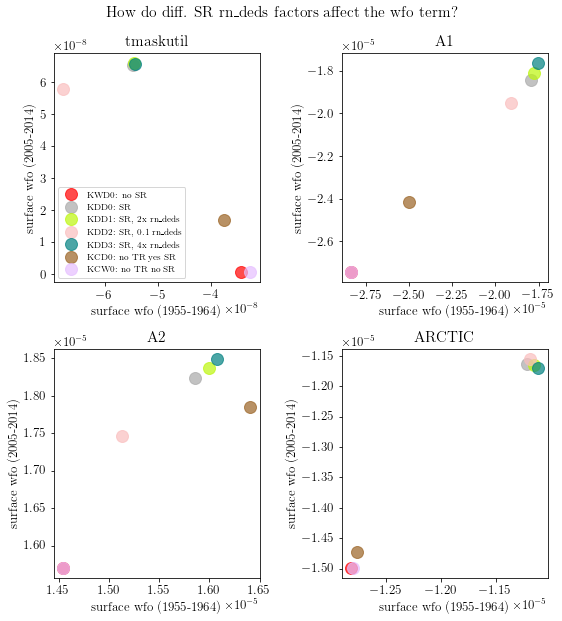

In [9]:
runs = ['KWD0','KDD0','KDD1','KDD2','KDD3','KCD0','KCW0']
        # 'KFD0','KFD1','KFD2',\
        # 'KFD3','KFD4','KFD5','KFD6',\
        # 'KFD7',]

# runs = ['KFD6']

fact = 0.8
fig, axs = plt.subplots(2,2, figsize=(10*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

col_labels = ['tmaskutil','A1','A2','ARCTIC']
#mis

ofs = 5.2
mis = [33,30.7, 33.5, 27]

for i in range(0,4):
    col = col_labels[i]
    

    
    for r in runs:
        desc = modi[r]['tdesc']
        axs[i].plot(wfo_1955.loc[r, col],wfo_2005.loc[r, col], 
                    marker = 'o', markersize = 12, color = modi[r]['tcol'],
                   label = f'{r}: {desc}', alpha = 0.7, linewidth = 0)
    
    
    
    # axs[i].plot([27,40],[27,40],'k-', alpha = 0.3)
    # axs[i].set_xlim([mis[i],mis[i]+ofs])
    # axs[i].set_ylim([mis[i],mis[i]+ofs])
    axs[i].set_ylabel('surface wfo (2005-2014)')
    axs[i].set_xlabel('surface wfo (1955-1964)')
    axs[i].set_title(col)
    axs[0].legend(ncol = 1, fontsize = 9, loc = 'best')
    
plt.suptitle('How do diff. SR rn_deds factors affect the wfo term?')
plt.tight_layout()

## visualise ts of wfo and sos

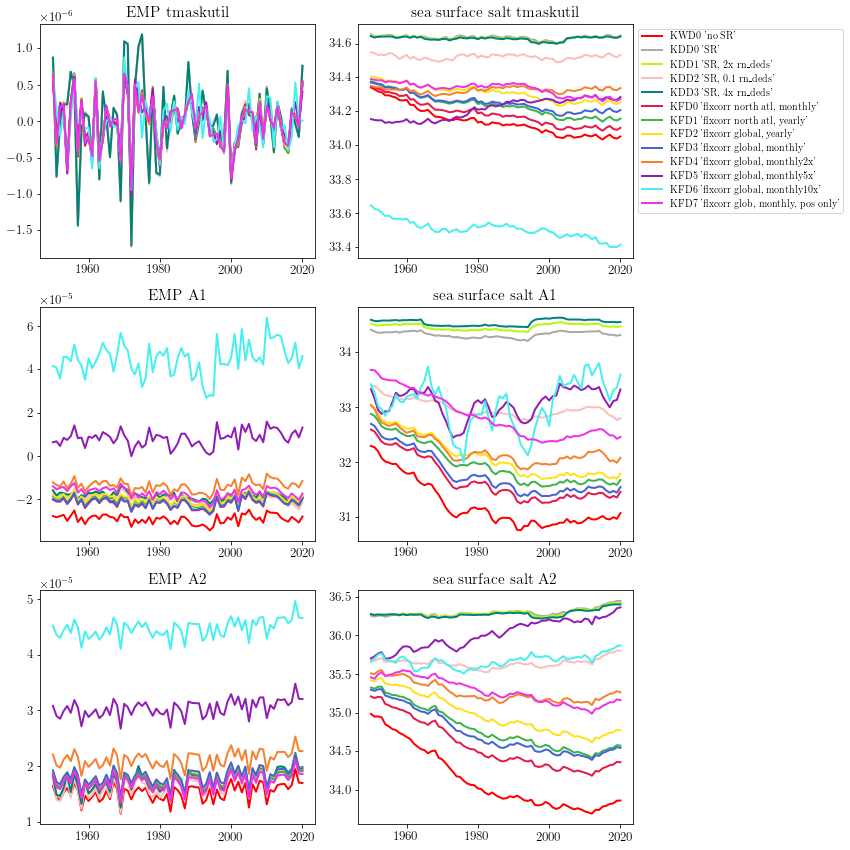

In [26]:
view = True

if view:

    runs = ['KWD0','KDD0','KDD1','KDD2','KDD3',
            'KFD0','KFD1','KFD2',\
            'KFD3','KFD4','KFD5','KFD6',\
            'KFD7',]

    fact = 1.5
    fig, axs = plt.subplots(3,2, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    tmask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/mesh_mask3_6.nc')
    
    regs = ['tmaskutil','A1','A2']

    ind = 0


    for treg in regs:
        for mod in runs:

            tvar = 'wfo'
            try:
                w = xr.open_dataset(f'./data/{mod}_{tvar}.nc')
                tmask['test'] = tmask['csize']*tmask[treg]
                w = w[tvar].weighted(tmask['test']).mean(dim = ['y','x'])
                w1 = w.groupby('time_counter.year').mean()
                desc = {modi[mod]['tdesc']}
                axs[ind*2].plot(w1.year, w1, linestyle = '-',\
                         color = modi[mod]['tcol'], lw = 2, label = f'{mod} {desc}')
                axs[ind*2].set_title(f'EMP {treg}') 
            except:
                print(f'no for {tvar} {mod} {treg}')

            tvar = 'sos'
            try:
                w = xr.open_dataset(f'./data/{mod}_{tvar}.nc')
                tmask['test'] = tmask['csize']*tmask[treg]
                w = w[tvar].weighted(tmask['test']).mean(dim = ['y','x'])
                w1 = w.groupby('time_counter.year').mean()
                desc = {modi[mod]['tdesc']}
                axs[ind*2+1].plot(w1.year, w1, linestyle = '-',\
                         color = modi[mod]['tcol'], lw = 2, label = f'{mod} {desc}')
                axs[ind*2+1].set_title(f'sea surface salt {treg}') 
            except:
                print(f'no for {tvar} {mod} {treg}')

               
        ind= ind+1

    axs[1].legend(bbox_to_anchor = [1,1], ncol = 1, fontsize = 10)

    plt.tight_layout()

## visualize AMOC

In [27]:
from datetime import datetime
import numpy as np

def numpy_datetime64_to_datetime(dt64: np.datetime64) -> datetime:
    """Convert numpy datetime64 to Python datetime."""
    return datetime.utcfromtimestamp(dt64.astype('datetime64[s]').astype(int))

def datetime_to_decimal(dt: datetime) -> float:
    """Convert a datetime object to decimal year."""
    year = dt.year
    start_of_year = datetime(year, 1, 1)
    end_of_year = datetime(year + 1, 1, 1)
    year_length = (end_of_year - start_of_year).total_seconds()
    elapsed = (dt - start_of_year).total_seconds()
    decimal_year = year + (elapsed / year_length)
    return round(decimal_year, 5)  # Rounded for better readability

def array_datetime_to_decimal(dates: np.ndarray) -> np.ndarray:
    """Convert an array of numpy.datetime64 objects to decimal years."""
    dt_list = [numpy_datetime64_to_datetime(dt) for dt in dates]
    return np.array([datetime_to_decimal(dt) for dt in dt_list])

# Example usage
#dt_array = np.array(['2021-01-01', '2021-06-15', '2021-12-31'], dtype='datetime64')
#print(array_datetime_to_decimal(dt_array))


dt_array = (monthly_moc.time).values
type(dt_array)
moc_dates = (array_datetime_to_decimal((monthly_moc.time).values))
yrmoc_dates = (array_datetime_to_decimal((yearly_moc.time).values))

NameError: name 'monthly_moc' is not defined

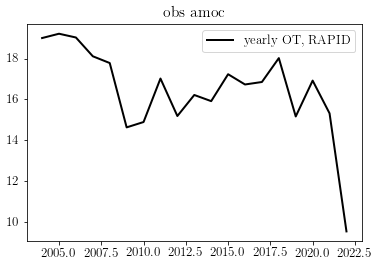

In [29]:
am = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/mocobs/moc_transports.nc')

#plt.plot(am.time,am.moc_mar_hc10, linestyle = '-', color = 'skyblue',  label = 'overturning transport, RAPID')
#monthly moc
# monthly_moc = am['moc_mar_hc10'].resample(time='1MS').mean()
#plt.plot(moc_dates, monthly_moc, 'r-', label = 'monthly OT, RAPID')

# yearly_moc = am['moc_mar_hc10'].resample(time='1YS').mean()
# plt.plot(yearly_moc.time, yearly_moc, 'k-', label = 'monthly OT, RAPID')


yrly_moc = am.groupby('time.year').mean() 
yrly_moc = am.groupby('time.year').mean() 

yrly_moc = am.groupby('time.year').mean() 
#axs.plot(yrly_moc.year, yrly_moc.moc_mar_hc10, 'k-', lw = 2, label = 'yearly OT, RAPID')
#axs.legend(bbox_to_anchor = [1,1])

plt.plot(yrly_moc.year, yrly_moc.moc_mar_hc10, 'k-', lw = 2, label = 'yearly OT, RAPID')
plt.title('obs amoc')
plt.legend(loc = 'best')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


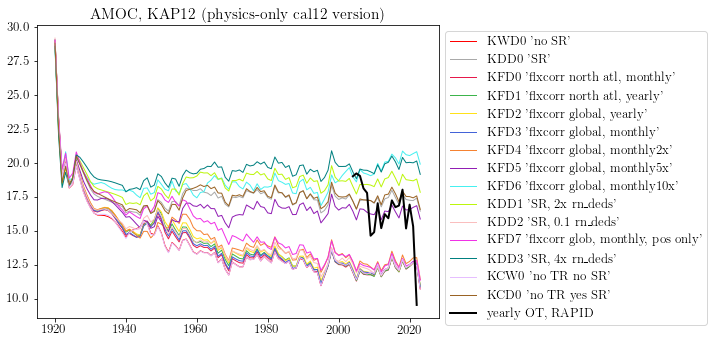

In [30]:
runs = ['KWD0','KDD0','KFD0','KFD1','KFD2',\
        'KFD3','KFD4','KFD5','KFD6','KDD1',\
        'KDD2','KFD7','KDD3','KCW0','KCD0']

fact = 0.9
fig, axs = plt.subplots(1,1, figsize=(8*fact, 6*fact), facecolor='w', edgecolor='k')


axs.set_title('AMOC, KAP12 (physics-only cal12 version)')
axs.legend()

for m in runs:
    try:
        w = xr.open_dataset(f'./data/{m}_max_amoc.nc')
        w1 = w.groupby('time_counter.year').mean()    
        desc = {modi[m]['tdesc']}
        axs.plot(w1.year,w1.amoc, color = modi[m]['tcol'], lw = 1, label = f'{m} {desc}')
    except:
        print(f'no {m}')
             
yrly_moc = am.groupby('time.year').mean() 
axs.plot(yrly_moc.year, yrly_moc.moc_mar_hc10, 'k-', lw = 2, label = 'yearly OT, RAPID')
axs.legend(bbox_to_anchor = [1,1])

## how does EMPave change when we change rn_deds? (not very much)

In [ ]:
mods = ['KWD0','KDD0','KFD0','KFD1','KFD2',\
    'KFD3','KFD4','KFD5','KFD6','KDD1',\
    'KDD2','KFD7']

mods = ['KDD0','KDD1','KDD3']

tvar = 'wfo'
tm = 5e-5
fact = 1.5
fig, axs = plt.subplots(2,3, figsize=(12*fact, 7*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


for i in range(0,3):
    
    m = mods[i]
    basemod = xr.open_dataset(f'./data/KWD0_{tvar}.nc')
    testmod = xr.open_dataset(f'./data/{m}_{tvar}.nc')

    tdiff = basemod-testmod
    tdiff_clim = tdiff.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).\
    groupby("time_counter.season").mean("time_counter")
    axs[i].pcolormesh(tdiff_clim[tvar].sel(season = 'DJF').values, vmin = -1*tm, vmax = tm, cmap = cm.balance)
    desc = {modi[m]['tdesc']}
    axs[i].set_title(f'{tvar} base (no SR) - {m} \n ({desc}), DJF')
    im1 = axs[i+3].pcolormesh(tdiff_clim[tvar].sel(season = 'JJA').values, vmin = -1*tm, vmax = tm, cmap = cm.balance)
    axs[i+3].set_title(f'{tvar} base (no SR) - {m} \n ({desc}), JJA')
    
cbar = fig.colorbar(im1, ax=axs, orientation='vertical')
cbar.set_label("kg/m2/s")
               


In [ ]:
am = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/mocobs/moc_transports.nc')